In [1]:
# Se for rodar em alguma cloud
# !pip install pycocotools

# Bibliotecas

In [2]:
# Biblioteca padrão
import os
import sys
import time
import json
from importlib import reload  # (Descomente se necessário)
import random

# Bibliotecas de terceiros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from PIL import Image, ImageOps, ImageDraw
from scipy.optimize import curve_fit

# PyTorch e torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchinfo import summary
from torchvision import transforms, models
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
)
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision.transforms import ToTensor
from torchvision.transforms import functional as TF

# pycocotools
from pycocotools.coco import COCO

# (Descomente se necessário)
sys.path.append(r'C:\Users\Marlon\Nextcloud2\Code_HPE_ResNet\_arquivos_organizados')
import minhas_funcoes

# Descrição
Esse é o modelo mais simples de todos. Usando só uma camada totalmente conectada, que recebe como input as features extraídas pela ResNet, lembrando que o detector não foi treinado aqui.

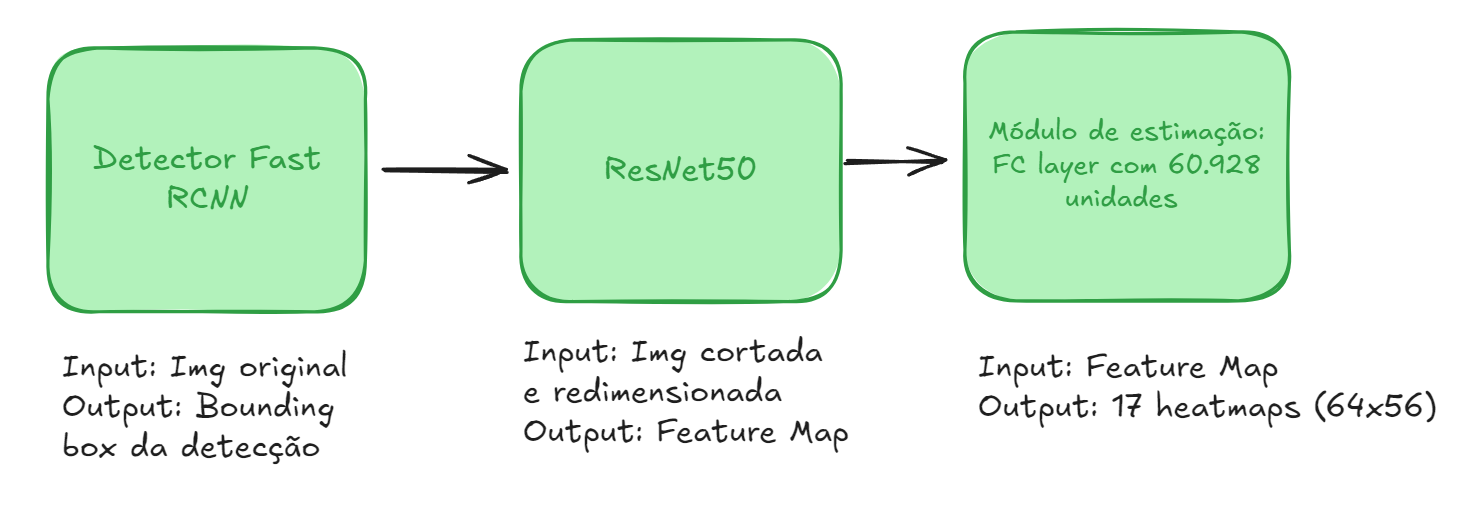

# 1 - Carregar resultado das detecções

In [3]:
path_deteccoes = r'C:\Users\Marlon\Nextcloud2\Code_HPE_ResNet\_arquivos_organizados\detector_treinado\deteccoes_finais.json'
with open(path_deteccoes, "r") as f:
    detecoes_transformadas_com_ids = json.load(f)

# 2 - Filtrar detecções válidas
Estou removendo as amostras onde algum ponto ficou de fora da bounding box.

In [4]:
# Teste local com subset pequeno
# ann_file = r'c:\Users\Marlon\Downloads\annotations\annotations\person_keypoints_val2017.json'
# path_imgs = r'C:\Users\Marlon\Downloads\COCO_Dataset\val2017'

# Kaggle
# ann_file = '/kaggle/input/coco-2017-dataset/coco2017/annotations/person_keypoints_train2017.json'
# path_imgs = '/kaggle/input/coco-2017-dataset/coco2017/train2017'

# Treinamento local
ann_file = r"c:\Users\Marlon\Downloads\annotations\annotations\person_keypoints_train2017.json"
path_imgs = r"C:\Users\Marlon\Downloads\train_images\train2017"

annotations_file = ann_file

img_ids_bboxes = detecoes_transformadas_com_ids
valid_samples, invalid_samples = minhas_funcoes.filter_images_by_keypoints(img_ids_bboxes, annotations_file)
print(f"Valid/Invalid samples: {len(valid_samples)}/{len(invalid_samples)}")
print(len(valid_samples))

loading annotations into memory...
Done (t=4.93s)
creating index...
index created!
Valid/Invalid samples: 15562/106
15562


# 3 - Classe
Classe usada para treinamento.

In [5]:
class COCOPoseDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotations_file, valid_samples, target_size=(256, 256), heatmap_size=(64, 64), transform=None):
        """
        Custom COCO pose dataset for keypoint heatmap generation.
        
        Args:
            image_dir (str): Directory containing the images.
            annotations_file (str): Path to the COCO annotations JSON file.
            valid_samples (list): List of tuples (image_id, bbox) for images with valid bboxes.
            target_size (tuple): Desired image size after resizing and padding (h, w).
            heatmap_size (tuple): Desired heatmap size for each keypoint (h, w).
        """
        self.image_dir = image_dir
        self.coco = COCO(annotations_file)
        self.valid_samples = valid_samples
        self.target_size = target_size  # (h, w)
        self.heatmap_size = heatmap_size  # (h, w)
        self.keypoint_names = [
            "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear", "Left Shoulder",
            "Right Shoulder", "Left Elbow", "Right Elbow", "Left Wrist", "Right Wrist",
            "Left Hip", "Right Hip", "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
        ]
        # Change here to load the transforms
        self.transform = transform
    
    def __len__(self):
        return len(self.valid_samples)
    
    def create_gaussian_heatmap(self, height, width, center_x, center_y, sigma=2):
        """Generates a 2D Gaussian heatmap centered at (center_x, center_y)."""
        x_grid, y_grid = np.meshgrid(np.arange(width), np.arange(height))
        d2 = (x_grid - center_x) ** 2 + (y_grid - center_y) ** 2
        gaussian = np.exp(-d2 / (2 * sigma ** 2))
        return gaussian

    def __getitem__(self, idx):
        # 1. Get the bounding box and image_id from valid_samples
        image_id, bbox = self.valid_samples[idx]

        # 2. Load image and retrieve annotation
        image_info = self.coco.loadImgs(image_id)[0]
        image_name = image_info['file_name']
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        image_width, image_height = image.size  # (w, h)

        # Adjust the bounding box if it exceeds the image boundaries
        x_min, y_min, width, height = bbox
        x_max = min(image_width, x_min + width)
        y_max = min(image_height, y_min + height)
        x_min, y_min = max(0, x_min), max(0, y_min)
        width, height = x_max - x_min, y_max - y_min

        # Crop the image using the adjusted bounding box
        image_cropped = image.crop((x_min, y_min, x_min + width, y_min + height))

        # Resize the cropped image to the target size
        aspect_ratio = image_cropped.height / image_cropped.width
        if aspect_ratio > 1:
            new_height = self.target_size[0]
            new_width = int(self.target_size[1] / aspect_ratio)
        else:
            new_width = self.target_size[1]
            new_height = int(self.target_size[0] * aspect_ratio)

        image_resized = image_cropped.resize((new_width, new_height), Image.LANCZOS)
        delta_h, delta_w = self.target_size[0] - new_height, self.target_size[1] - new_width
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        image_padded = ImageOps.expand(image_resized, padding, fill=(0, 0, 0))

        # Load and adjust keypoints
        ann_ids = self.coco.getAnnIds(imgIds=image_id, catIds=[self.coco.getCatIds(catNms=['person'])[0]], iscrowd=False)
        annotations = self.coco.loadAnns(ann_ids)
        keypoints = annotations[0]['keypoints']
        keypoints = [(keypoints[i], keypoints[i + 1], keypoints[i + 2]) for i in range(0, len(keypoints), 3)]
        adjusted_keypoints = [(x - x_min, y - y_min, v) for x, y, v in keypoints]
        scale_y, scale_x = new_height / height, new_width / width
        scaled_keypoints = [(x * scale_x, y * scale_y, v) for x, y, v in adjusted_keypoints]
        adjusted_keypoints_padded = [(x + padding[0], y + padding[1], v) for x, y, v in scaled_keypoints]

        # Generate heatmaps for each keypoint
        scale_y_hm = self.heatmap_size[0] / self.target_size[0]
        scale_x_hm = self.heatmap_size[1] / self.target_size[1]
        heatmaps = []
        for x, y, v in adjusted_keypoints_padded:
            if v == 2:
                x_hm, y_hm = int(x * scale_x_hm), int(y * scale_y_hm)
                heatmap = self.create_gaussian_heatmap(self.heatmap_size[0], self.heatmap_size[1], x_hm, y_hm, sigma=2)
            else:
                # Also i think i will change this behaviour
                # It can be better to create a heatmap with the peak at (0,0), just like in the dataset right?
                heatmap = np.zeros(self.heatmap_size)
                
            heatmaps.append(torch.tensor(heatmap))

        # Convert final image to tensor and return
        image_tensor = torch.tensor(np.array(image_padded)).permute(2, 0, 1).float() / 255.0
        # heatmaps_tensor = torch.stack(heatmaps)
        heatmaps_tensor = torch.stack(heatmaps).float()  # Ensure float dtype for heatmaps

        # If you have a transform for image+heatmaps:
        if self.transform is not None:
            # image_tensor should be a float tensor and heatmaps_tensor a float tensor before transform
            # Make sure both are on CPU and float type
            # image_tensor = image_tensor.to(torch.float)
            # heatmaps_tensor = heatmaps_tensor.to(torch.float)
            image_tensor, heatmaps_tensor = self.transform(image_tensor, heatmaps_tensor)

        return image_tensor, heatmaps_tensor, adjusted_keypoints_padded


## 3.1 Classe para sincronizar augment

In [6]:
class MyPairTransform:
    def __init__(self):
        pass

    def __call__(self, image_tensor, heatmaps_tensor):
        # Ensure image_tensor is float in range [0, 1]
        assert image_tensor.dtype == torch.float, "Image tensor must be of dtype torch.float"
        assert image_tensor.max() <= 1.0, "Image tensor values must be in range [0, 1]"

        # Horizontal flip
        if random.random() < 0.5:
            image_tensor = TF.hflip(image_tensor)
            heatmaps_tensor = torch.flip(heatmaps_tensor, dims=[2])  # Flip along width (W)

        # Random rotation
        angle = random.uniform(-15, 15)
        image_tensor = TF.rotate(image_tensor, angle)  # Rotate image tensor
        heatmaps_tensor = TF.rotate(heatmaps_tensor.unsqueeze(1), angle).squeeze(1)  # Rotate heatmaps

        # Add more transformations as needed

        return image_tensor, heatmaps_tensor

# 4 - Inicializar modelo de estimação

In [7]:
# Inputs size
size_input = (256, 224)
size_heatmap = (64, 56)

# Modelo
weights = models.ResNet50_Weights.IMAGENET1K_V1
model = models.resnet50(weights=weights)

# Modifica ultima layer
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_features, 17 * size_heatmap[0] * size_heatmap[1]),
    torch.nn.Unflatten(1, (17, size_heatmap[0], size_heatmap[1]))
)

# Move the Model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}")

# Loss
criterion = torch.nn.MSELoss()
# Optimizer
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
# Adaptative LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

Model moved to cuda


c:\Users\Marlon\miniforge3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 5 - Setup data augment e data loader

In [8]:
# Define transformations for data augmentation and normalization

transform = MyPairTransform()

# Update the dataset class to apply transformations
dataset = COCOPoseDataset(path_imgs, annotations_file, valid_samples, size_input, size_heatmap, transform=transform)

# Split dataset into training and validation
val_split = 0.1
dataset_size = len(dataset)
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
# batch_size = 64
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



loading annotations into memory...
Done (t=4.51s)
creating index...
index created!


# 6 - Loss

In [9]:
# Assuming `model` is already defined; replace with your model initialization if not
criterion = nn.MSELoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# 7 - Loop de treinamento

In [10]:
# Store losses for plotting later
train_losses = []
val_losses = []

# Initialize a list to store learning rates
learning_rate_log = []

# Training parameters
num_epochs = 2
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0
patience_counter = 0  # Initialize the patience counter

# Minimum number of epochs
min_epochs = 50
max_epochs = 200

print("Starting training...")

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Track epoch start time
    running_loss = 0.0
    val_loss = 0.0
    model.train()  # Set model to training mode

    # Training loop
    for inputs, heatmaps, _ in tqdm(train_loader, desc="Training Bacthes"):
        inputs, heatmaps = inputs.float().to(device), heatmaps.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        """
        - Masking the validation loss for visible points
        - Avaliar depois impacto da validation mask
        - Acho que é melhor manter, se remover podemos acabar penalizando o modelo por não prever pontos que não são visíveis
        """
        mask = (heatmaps.sum(dim=(2, 3)) > 0).float().unsqueeze(-1).unsqueeze(-1)  # Shape: [batch_size, num_keypoints, 1, 1]
        visible_outputs = outputs * mask  # Apply mask to outputs
        visible_heatmaps = heatmaps * mask  # Apply mask to ground truth heatmaps

        # Compute masked loss
        loss = criterion(visible_outputs, visible_heatmaps)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    # Após o loop de treinamento, calcular a média da loss
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_train_loss:.8f}")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for val_inputs, val_heatmaps, _ in val_loader:
            val_inputs, val_heatmaps = val_inputs.float().to(device), val_heatmaps.float().to(device)

            val_outputs = model(val_inputs)

            val_mask = (val_heatmaps.sum(dim=(2, 3)) > 0).float().unsqueeze(-1).unsqueeze(-1)            
            visible_val_outputs = val_outputs * val_mask
            visible_val_heatmaps = val_heatmaps * val_mask

            # Compute validation loss
            val_loss += criterion(visible_val_outputs, visible_val_heatmaps).item() * val_inputs.size(0)
    
    # Validation loss   
    epoch_val_loss = val_loss / len(val_loader.dataset)    
    val_losses.append(epoch_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Loss: {epoch_val_loss:.8f}")
    
    # Epoch end time
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch + 1} took {epoch_duration:.2f} seconds.")

    # Record the learning rate after each epoch
    current_lr = optimizer.param_groups[0]['lr']  # Assuming a single parameter group
    learning_rate_log.append(current_lr)
    print(f"Epoch {epoch+1}, Learning Rate: {current_lr}")
    
    # Check for Early Stopping and Save Best Model Checkpoint
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        save_path = f"change_saved_file_name.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss
        }, save_path)  # Save the best model checkpoint
        print("Model improved. Saving the best model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience and epoch >= min_epochs:
        print(f"Min number epochs reached, with no improvement in validation loss. Stopping training.")
        break
    
    # If gets to max number of epochs
    if epoch == max_epochs:
        print(f"Reached maximum number of epochs ({max_epochs}). Stopping training.")
        break
    
    # Step the scheduler
    scheduler.step(epoch_val_loss)

# Save the learning rate log to a file (optional)
with open("learning_rate_log.txt", "w") as f:
    for lr in learning_rate_log:
        f.write(f"{lr}\n")

print(f"End training loop after {epoch + 1} epochs.")

Starting training...


Training Bacthes:   1%|▏         | 13/876 [00:12<13:49,  1.04it/s]


KeyboardInterrupt: 